# **IPL Match winner prediction model**

This notebook analyzes IPL data from 2015 to 2024, covering data collection, preprocessing, and exploratory analysis. It highlights key metrics like win rates, player performance, and team stats. Using statistical methods, it identifies factors affecting match results. An ensemble model combining Random Forest and XGBoost is used to predict the 2024 IPL season match winner, with details on features, training, validation, and performance. Future work includes adding real-time data and testing neural networks. The results section presents 2024 predictions, discussing model strengths, weaknesses, and insights into teams and players. The goal is to apply machine learning to forecast IPL match outcomes using historical data.

# **1.Imports and Load Data**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [ ]:
deliveries_df = pd.read_csv('deliveries.csv').iloc[108850:].reset_index(drop=True)
matches_df = pd.read_csv('matches.csv').iloc[458:].reset_index(drop=True)

deliveries = deliveries_df.copy()
matches = matches_df.copy()

print("Deliveries shape:", deliveries.shape)
print("Matches shape:", matches.shape)


Deliveries shape: (152070, 17)
Matches shape: (637, 20)


# **2.EDA and Feature Extraction**

In [ ]:
# Mapping dictionary for old names to standardized names
team_name_mapping = {
    'Delhi Daredevils': 'Delhi Capitals',
    'Kings XI Punjab': 'Punjab Kings',
    'Rising Pune Supergiants': 'Chennai Super Kings',
    'Rising Pune Supergiant': 'Chennai Super Kings',
    'Gujarat Lions': 'Gujarat Titans',
    'Deccan Chargers': 'Sunrisers Hyderabad',
    'Royal Challengers Bengaluru': 'Royal Challengers Bangalore',
}

team_columns = ['winner', 'team1', 'team2', 'toss_winner']

# Replace the team names in the 'winner' column
matches[team_columns] = matches[team_columns].replace(team_name_mapping)

In [ ]:
teams = pd.concat([matches['team1'], matches['team2']]).unique()
team_stats = pd.DataFrame(teams, columns=['team_name'])

team_stats

,team_name
0,Kolkata Knight Riders
1,Chennai Super Kings
2,Punjab Kings
3,Delhi Capitals
4,Mumbai Indians
5,Royal Challengers Bangalore
6,Rajasthan Royals
7,Sunrisers Hyderabad
8,Gujarat Titans
9,Lucknow Super Giants


In [ ]:
# Calculate matches played and won
team_stats['matches_played'] = team_stats['team_name'].apply(lambda x: len(matches[(matches['team1'] == x) | (matches['team2'] == x)]))
team_stats['matches_won'] = team_stats['team_name'].apply(lambda x: len(matches[matches['winner'] == x]))
team_stats['win_percentage'] = (team_stats['matches_won'] / team_stats['matches_played']) * 100

team_stats

,team_name,matches_played,matches_won,win_percentage
0,Kolkata Knight Riders,147,78,53.061224
1,Chennai Super Kings,154,84,54.545455
2,Punjab Kings,140,56,40.000000
3,Delhi Capitals,147,71,48.299320
4,Mumbai Indians,151,81,53.642384
5,Royal Challengers Bangalore,148,70,47.297297
6,Rajasthan Royals,117,56,47.863248
7,Sunrisers Hyderabad,151,72,47.682119
8,Gujarat Titans,75,41,54.666667
9,Lucknow Super Giants,44,24,54.545455


In [ ]:
# Exclude no-result matches from deliveries
no_result_match_ids = [501265, 829763, 829813, 1178424, 1359519]
filtered_deliveries = deliveries[~deliveries['match_id'].isin(no_result_match_ids)]

# Highest and lowest scores excluding no-result matches
highest_scores = filtered_deliveries.groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()
team_stats['highest_score'] = team_stats['team_name'].apply(lambda x: highest_scores[highest_scores['batting_team'] == x]['total_runs'].max())
team_stats['lowest_score'] = team_stats['team_name'].apply(lambda x: highest_scores[highest_scores['batting_team'] == x]['total_runs'].min())

In [ ]:
# Total 4s and 6s
team_stats['total_4s'] = team_stats['team_name'].apply(lambda x: deliveries[(deliveries['batting_team'] == x) & (filtered_deliveries['batsman_runs'] == 4)].shape[0])
team_stats['total_6s'] = team_stats['team_name'].apply(lambda x: deliveries[(deliveries['batting_team'] == x) & (filtered_deliveries['batsman_runs'] == 6)].shape[0])

# Average Powerplay and Death overs scores
powerplay_scores = deliveries[(deliveries['over'] <= 6)].groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()
death_overs_scores = deliveries[(deliveries['over'] > 15)].groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()

team_stats['average_powerplay_score'] = team_stats['team_name'].apply(lambda x: powerplay_scores[powerplay_scores['batting_team'] == x]['total_runs'].mean())
team_stats['average_death_overs_score'] = team_stats['team_name'].apply(lambda x: death_overs_scores[death_overs_scores['batting_team'] == x]['total_runs'].mean())

team_stats

,team_name,matches_played,matches_won,win_percentage,highest_score,lowest_score,total_4s,total_6s,average_powerplay_score,average_death_overs_score
0,Kolkata Knight Riders,147,78,53.061224,272,48,2111,1052,57.571429,36.860465
1,Chennai Super Kings,154,84,54.545455,235,71,1675,863,54.032520,40.391667
2,Punjab Kings,140,56,40.000000,262,106,795,440,57.696429,38.622642
3,Delhi Capitals,147,71,48.299320,257,92,1352,550,58.879121,35.292135
4,Mumbai Indians,151,81,53.642384,247,87,2144,1140,55.933775,40.211268
5,Royal Challengers Bangalore,148,70,47.297297,248,49,1719,867,54.353383,38.934959
6,Rajasthan Royals,117,56,47.863248,226,59,1646,760,57.068966,37.693694
7,Sunrisers Hyderabad,151,72,47.682119,287,72,2042,916,57.390728,36.251748
8,Gujarat Titans,75,41,54.666667,233,89,691,271,55.644444,41.431818
9,Lucknow Super Giants,44,24,54.545455,257,82,571,328,53.522727,40.904762


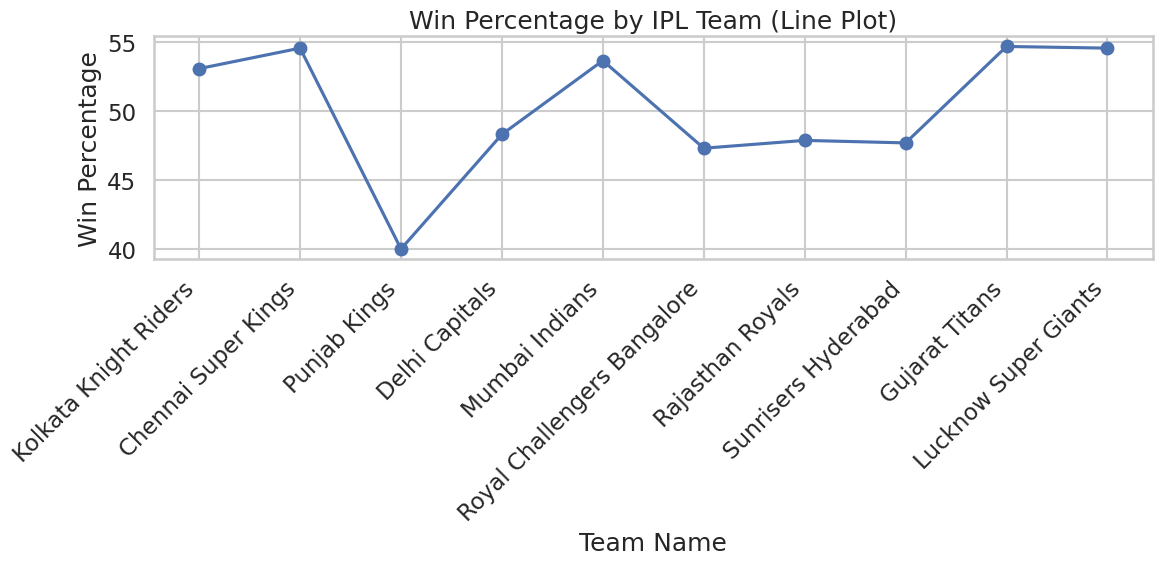

In [ ]:
# Create the line plot
plt.figure(figsize=(12, 6))
plt.plot(
    team_stats['team_name'],
    team_stats['win_percentage'],
    marker='o',
    linestyle='-'
)

# Labeling
plt.xlabel('Team Name')
plt.ylabel('Win Percentage')
plt.title('Win Percentage by IPL Team (Line Plot)')

# Rotate x‑axis labels for readability
plt.xticks(rotation=45, ha='right')

# Tight layout to prevent clipping of tick-labels
plt.tight_layout()

# Show the plot
plt.show()


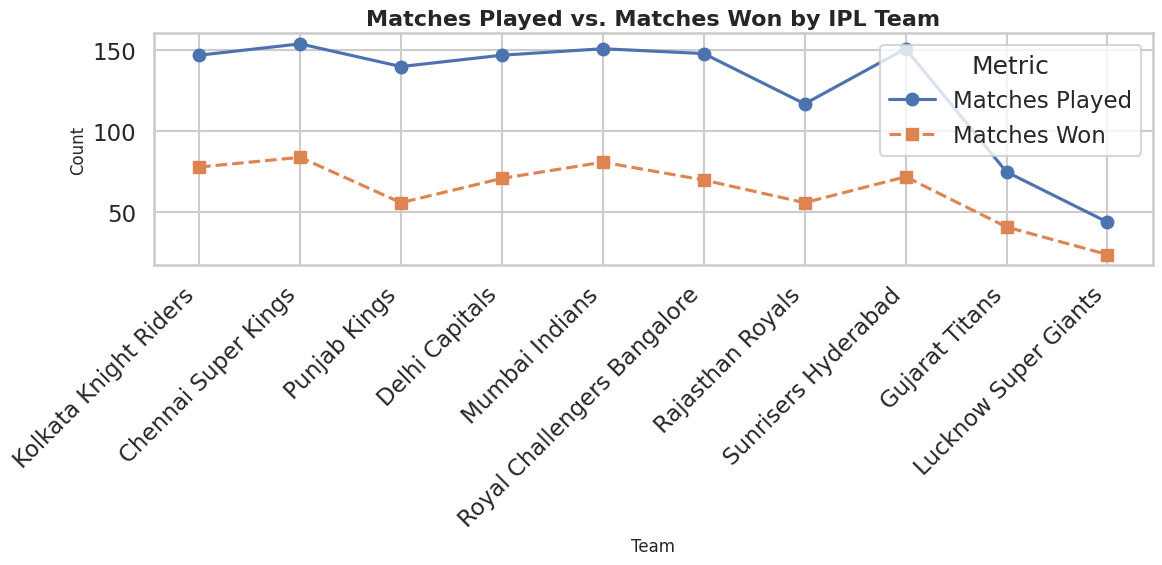

In [ ]:
teams = team_stats['team_name']
played = team_stats['matches_played']
won = team_stats['matches_won']

plt.figure(figsize=(12, 6))

# Plot Matches Played
plt.plot(
    teams,
    played,
    marker='o',
    linestyle='-',
    label='Matches Played'
)

# Plot Matches Won
plt.plot(
    teams,
    won,
    marker='s',
    linestyle='--',
    label='Matches Won'
)

# Labels and title
plt.xlabel('Team', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Matches Played vs. Matches Won by IPL Team', fontsize=16, fontweight='bold')

# Rotate x labels for readability
plt.xticks(rotation=45, ha='right')

# Legend
plt.legend(title='Metric')

# Layout adjustment
plt.tight_layout()

# Show plot
plt.show()


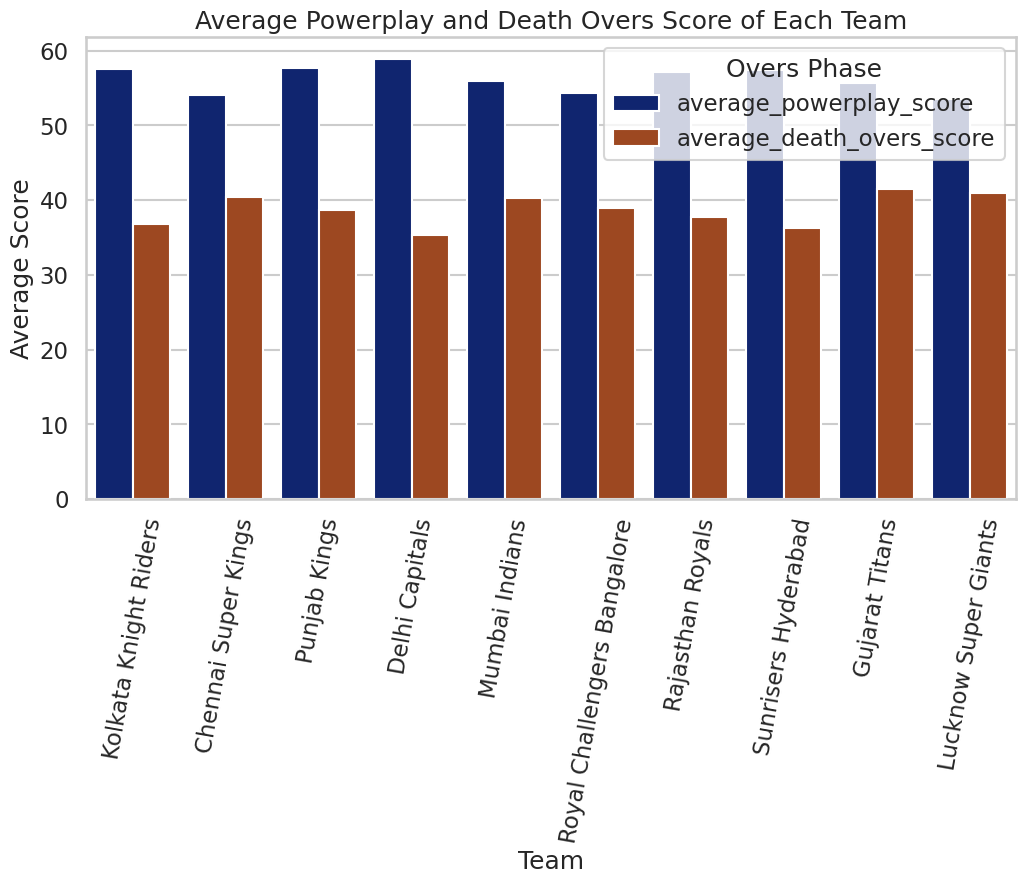

In [ ]:
# Plotting Average Powerplay and Death Overs Score
plt.figure(figsize=(12, 6))
team_stats_melted = team_stats.melt(id_vars=['team_name'], value_vars=['average_powerplay_score', 'average_death_overs_score'],
                                    var_name='Overs Phase', value_name='Average Score')
sns.barplot(x='team_name', y='Average Score', hue='Overs Phase', data=team_stats_melted, palette='dark')
plt.title('Average Powerplay and Death Overs Score of Each Team')
plt.xlabel('Team')
plt.ylabel('Average Score')
plt.xticks(rotation=80)
plt.show()

# **3. Winner Prediction Model**

In [ ]:
deliveries = deliveries_df.copy()
matches = matches_df.copy()

In [ ]:
inning_scores = deliveries.groupby(['match_id', 'inning']).sum()['total_runs'].reset_index()
inning_scores = inning_scores[inning_scores['inning']==1]
inning_scores['target'] = inning_scores['total_runs'] + 1
inning_scores.head()

,match_id,inning,total_runs,target
0,829705,1,168,169
2,829707,1,150,151
4,829709,1,162,163
6,829711,1,209,210
8,829713,1,177,178


In [ ]:
matches.rename(columns={'id': 'match_id'}, inplace=True)
matches = matches.merge(inning_scores[['match_id','target']], on='match_id')
matches.head()

,match_id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,...,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,target
0,829705,2015,Kolkata,2015-04-08,League,M Morkel,Eden Gardens,Kolkata Knight Riders,Mumbai Indians,Kolkata Knight Riders,...,Kolkata Knight Riders,wickets,7.0,169.0,20.0,N,NaN,S Ravi,C Shamshuddin,169
1,829707,2015,Chennai,2015-04-09,League,A Nehra,"MA Chidambaram Stadium, Chepauk",Chennai Super Kings,Delhi Daredevils,Delhi Daredevils,...,Chennai Super Kings,runs,1.0,151.0,20.0,N,NaN,RK Illingworth,VA Kulkarni,151
2,829709,2015,Pune,2015-04-10,League,JP Faulkner,Maharashtra Cricket Association Stadium,Kings XI Punjab,Rajasthan Royals,Kings XI Punjab,...,Rajasthan Royals,runs,26.0,163.0,20.0,N,NaN,SD Fry,CB Gaffaney,163
3,829711,2015,Chennai,2015-04-11,League,BB McCullum,"MA Chidambaram Stadium, Chepauk",Chennai Super Kings,Sunrisers Hyderabad,Chennai Super Kings,...,Chennai Super Kings,runs,45.0,210.0,20.0,N,NaN,RK Illingworth,VA Kulkarni,210
4,829713,2015,Kolkata,2015-04-11,League,CH Gayle,Eden Gardens,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,...,Royal Challengers Bangalore,wickets,3.0,178.0,20.0,N,NaN,S Ravi,C Shamshuddin,178


In [ ]:
matches['team1'].unique()

array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Kings XI Punjab',
       'Delhi Daredevils', 'Mumbai Indians',
       'Royal Challengers Bangalore', 'Rajasthan Royals',
       'Sunrisers Hyderabad', 'Gujarat Lions', 'Rising Pune Supergiants',
       'Rising Pune Supergiant', 'Delhi Capitals', 'Punjab Kings',
       'Lucknow Super Giants', 'Gujarat Titans',
       'Royal Challengers Bengaluru'], dtype=object)

In [ ]:
# Mapping dictionary for old names to standardized names
team_name_mapping = {
    'Delhi Daredevils': 'Delhi Capitals',
    'Kings XI Punjab': 'Punjab Kings',
    'Rising Pune Supergiants': 'Chennai Super Kings',
    'Rising Pune Supergiant': 'Chennai Super Kings',
    'Gujarat Lions': 'Gujarat Titans',
    'Deccan Chargers': 'Sunrisers Hyderabad',
    'Royal Challengers Bengaluru': 'Royal Challengers Bangalore',
}

team_columns = ['winner', 'team1', 'team2', 'toss_winner']

# Replace the team names in team columns
matches[team_columns] = matches[team_columns].replace(team_name_mapping)

In [ ]:
# Teams that will play in 2024 season
teams_2024 = [
    'Chennai Super Kings',
    'Delhi Capitals',
    'Gujarat Titans',
    'Kolkata Knight Riders',
    'Lucknow Super Giants',
    'Mumbai Indians',
    'Punjab Kings',
    'Rajasthan Royals',
    'Royal Challengers Bangalore',
    'Sunrisers Hyderabad',
]

# Extracting only the selected teams
matches = matches[matches['team1'].isin(teams_2024)]
matches = matches[matches['team2'].isin(teams_2024)]

matches.head()

,match_id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,...,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,target
0,829705,2015,Kolkata,2015-04-08,League,M Morkel,Eden Gardens,Kolkata Knight Riders,Mumbai Indians,Kolkata Knight Riders,...,Kolkata Knight Riders,wickets,7.0,169.0,20.0,N,NaN,S Ravi,C Shamshuddin,169
1,829707,2015,Chennai,2015-04-09,League,A Nehra,"MA Chidambaram Stadium, Chepauk",Chennai Super Kings,Delhi Capitals,Delhi Capitals,...,Chennai Super Kings,runs,1.0,151.0,20.0,N,NaN,RK Illingworth,VA Kulkarni,151
2,829709,2015,Pune,2015-04-10,League,JP Faulkner,Maharashtra Cricket Association Stadium,Punjab Kings,Rajasthan Royals,Punjab Kings,...,Rajasthan Royals,runs,26.0,163.0,20.0,N,NaN,SD Fry,CB Gaffaney,163
3,829711,2015,Chennai,2015-04-11,League,BB McCullum,"MA Chidambaram Stadium, Chepauk",Chennai Super Kings,Sunrisers Hyderabad,Chennai Super Kings,...,Chennai Super Kings,runs,45.0,210.0,20.0,N,NaN,RK Illingworth,VA Kulkarni,210
4,829713,2015,Kolkata,2015-04-11,League,CH Gayle,Eden Gardens,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,...,Royal Challengers Bangalore,wickets,3.0,178.0,20.0,N,NaN,S Ravi,C Shamshuddin,178


In [ ]:
map_city_names = {'Bengaluru': 'Bangalore'}
matches['city'] = matches['city'].replace(map_city_names)

matches['city'].unique()

array(['Kolkata', 'Chennai', 'Pune', 'Delhi', 'Mumbai', 'Bangalore',
       'Ahmedabad', 'Visakhapatnam', 'Chandigarh', 'Hyderabad', 'Raipur',
       'Ranchi', 'Rajkot', 'Kanpur', 'Indore', 'Jaipur', 'Abu Dhabi', nan,
       'Dubai', 'Sharjah', 'Navi Mumbai', 'Lucknow', 'Guwahati',
       'Dharamsala', 'Mohali'], dtype=object)

In [ ]:
# Extracting only selected columns
matches = matches[['match_id', 'season', 'city', 'team1', 'team2', 'winner', 'target']].dropna()
matches.head()

,match_id,season,city,team1,team2,winner,target
0,829705,2015,Kolkata,Kolkata Knight Riders,Mumbai Indians,Kolkata Knight Riders,169
1,829707,2015,Chennai,Chennai Super Kings,Delhi Capitals,Chennai Super Kings,151
2,829709,2015,Pune,Punjab Kings,Rajasthan Royals,Rajasthan Royals,163
3,829711,2015,Chennai,Chennai Super Kings,Sunrisers Hyderabad,Chennai Super Kings,210
4,829713,2015,Kolkata,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,178


In [ ]:
matches.isnull().sum()

,0
match_id,0
season,0
city,0
team1,0
team2,0
winner,0
target,0


In [ ]:
# Replace the team names in the 'batting_team' column
deliveries['batting_team'] = deliveries['batting_team'].replace(team_name_mapping)
deliveries['bowling_team'] = deliveries['bowling_team'].replace(team_name_mapping)

deliveries = deliveries[deliveries['batting_team'].isin(teams_2024)]
deliveries = deliveries[deliveries['bowling_team'].isin(teams_2024)]
deliveries.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,829705,1,Mumbai Indians,Kolkata Knight Riders,0,1,RG Sharma,UT Yadav,AJ Finch,0,0,0,NaN,0,NaN,NaN,NaN
1,829705,1,Mumbai Indians,Kolkata Knight Riders,0,2,RG Sharma,UT Yadav,AJ Finch,1,0,1,NaN,0,NaN,NaN,NaN
2,829705,1,Mumbai Indians,Kolkata Knight Riders,0,3,AJ Finch,UT Yadav,RG Sharma,1,0,1,NaN,0,NaN,NaN,NaN
3,829705,1,Mumbai Indians,Kolkata Knight Riders,0,4,RG Sharma,UT Yadav,AJ Finch,1,0,1,NaN,0,NaN,NaN,NaN
4,829705,1,Mumbai Indians,Kolkata Knight Riders,0,5,AJ Finch,UT Yadav,RG Sharma,0,1,1,legbyes,0,NaN,NaN,NaN


In [ ]:
# Merge to the final dataset
final = matches.merge(deliveries, on='match_id')
# Get only second inning matches
final = final[final['inning'] == 2]

# Add current score, remaining runs, remaining balls , remaining wickets column
final.loc[:, 'current_score'] = final.groupby('match_id')['total_runs'].cumsum()
final.loc[:, 'runs_left'] = np.where(final['target']-final['current_score']>=0, final['target']-final['current_score'], 0)
final.loc[:, 'balls_left'] = np.where(120 - final['over']*6 - final['ball']>=0, 120 - final['over']*6 - final['ball'], 0)
final.loc[:, 'wickets_left'] = 10 - final.groupby('match_id')['is_wicket'].cumsum()


# Calculate 'current_run_rate'
final['current_run_rate'] = np.where(
    120 - final['balls_left'] > 0,
    (final['current_score'] * 6) / (120 - final['balls_left']),
    0
)

# Calculate 'required_run_rate'
final['required_run_rate'] = np.where(
    final['balls_left'] > 0,
    (final['runs_left'] * 6) / final['balls_left'],
    np.where(final['runs_left'] > 0, 1e6, 0)
)

def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

final['result'] = final.apply(result, axis=1)

final.head()

,match_id,season,city,team1,team2,winner,target,inning,batting_team,bowling_team,...,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left,wickets_left,current_run_rate,required_run_rate,result
122,829705,2015,Kolkata,Kolkata Knight Riders,Mumbai Indians,Kolkata Knight Riders,169,2,Kolkata Knight Riders,Mumbai Indians,...,NaN,NaN,NaN,1,168,119,10,6.0,8.470588,1
123,829705,2015,Kolkata,Kolkata Knight Riders,Mumbai Indians,Kolkata Knight Riders,169,2,Kolkata Knight Riders,Mumbai Indians,...,NaN,NaN,NaN,2,167,118,10,6.0,8.491525,1
124,829705,2015,Kolkata,Kolkata Knight Riders,Mumbai Indians,Kolkata Knight Riders,169,2,Kolkata Knight Riders,Mumbai Indians,...,NaN,NaN,NaN,3,166,117,10,6.0,8.512821,1
125,829705,2015,Kolkata,Kolkata Knight Riders,Mumbai Indians,Kolkata Knight Riders,169,2,Kolkata Knight Riders,Mumbai Indians,...,NaN,NaN,NaN,3,166,116,10,4.5,8.586207,1
126,829705,2015,Kolkata,Kolkata Knight Riders,Mumbai Indians,Kolkata Knight Riders,169,2,Kolkata Knight Riders,Mumbai Indians,...,NaN,NaN,NaN,3,166,115,10,3.6,8.660870,1


In [ ]:
winning_pred = final[['season', 'batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets_left', 'current_run_rate', 'required_run_rate', 'target', 'result']]
winning_pred.head()

,season,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,current_run_rate,required_run_rate,target,result
122,2015,Kolkata Knight Riders,Mumbai Indians,Kolkata,168,119,10,6.0,8.470588,169,1
123,2015,Kolkata Knight Riders,Mumbai Indians,Kolkata,167,118,10,6.0,8.491525,169,1
124,2015,Kolkata Knight Riders,Mumbai Indians,Kolkata,166,117,10,6.0,8.512821,169,1
125,2015,Kolkata Knight Riders,Mumbai Indians,Kolkata,166,116,10,4.5,8.586207,169,1
126,2015,Kolkata Knight Riders,Mumbai Indians,Kolkata,166,115,10,3.6,8.660870,169,1


In [ ]:
season_2024 = winning_pred[winning_pred['season'] == '2024']
other_seasons = winning_pred[winning_pred['season'] != '2024']

# Define X and y for both datasets
X_train_23 = other_seasons.drop(['result', 'season'], axis=1)
y_train_23 = other_seasons['result']

X_test_24 = season_2024.drop(['result', 'season'], axis=1)
y_test_24 = season_2024['result']

# Verify the splits
print("Training set size:", X_train_23.shape, y_train_23.shape)
print("Test set size:", X_test_24.shape, y_test_24.shape)

Training set size: (60452, 9) (60452,)
Test set size: (8210, 9) (8210,)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Column transformer
trf = ColumnTransformer([
    ('cat', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), ['batting_team', 'bowling_team', 'city']),
    ('num', StandardScaler(), ['runs_left', 'balls_left', 'wickets_left', 'current_run_rate', 'required_run_rate', 'target'])
], remainder='passthrough')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# Define the pipeline with the XGBoost classifier
pipe = Pipeline(steps=[
    ('preprocessor', trf),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Hyperparameter tuning
param_distributions = {
    'classifier__n_estimators': randint(100, 301),  # Range [100, 300]
    'classifier__max_depth': randint(3, 10),        # Range [3, 9]
    'classifier__learning_rate': uniform(0.01, 0.19), # Range [0.01, 0.2]
    'classifier__subsample': uniform(0.5, 0.5),       # Range [0.5, 1.0]
    'classifier__colsample_bytree': uniform(0.3, 0.7) # Range [0.3, 1.0]
}

# Perform randomized search
random_search = RandomizedSearchCV(pipe, param_distributions, n_iter=100, cv=5, scoring='accuracy', random_state=42, n_jobs=-1, verbose=2)
random_search.fit(X_train_23, y_train_23)

# Best model
best_model_1 = random_search.best_estimator_
best_params_1 = random_search.best_params_
best_score_1 = random_search.best_score_

# Print the results
print(f"Best parameters: {best_params_1}")
print(f"Best cross-validation score: {best_score_1}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'classifier__colsample_bytree': np.float64(0.47088786557344187), 'classifier__learning_rate': np.float64(0.04197529801285681), 'classifier__max_depth': 3, 'classifier__n_estimators': 279, 'classifier__subsample': np.float64(0.681814801189647)}
Best cross-validation score: 0.7456163547194732


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

pipe = Pipeline(steps=[
    ('preprocessor', trf),
    ('classifier', RandomForestClassifier())
])

# Hyperparameter tuning
param_distributions = {
    'classifier__n_estimators': randint(100, 301),  # Range [100, 300]
    'classifier__max_depth': randint(10, 31),       # Range [10, 30]
    'classifier__min_samples_split': randint(2, 11) # Range [2, 10]
}

# Perform randomized search
random_search = RandomizedSearchCV(pipe, param_distributions, n_iter=100, cv=5, scoring='accuracy', random_state=42, n_jobs=-1, verbose=2)
random_search.fit(X_train_23, y_train_23)

# Best model
best_model_2 = random_search.best_estimator_
best_params_2 = random_search.best_params_
best_score_2 = random_search.best_score_

# Print the results
print(f"Best parameters: {best_params_2}")
print(f"Best cross-validation score: {best_score_2}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'classifier__max_depth': 13, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 203}
Best cross-validation score: 0.752382457568293


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create a voting classifier combining these models
final_model = VotingClassifier(estimators=[
    ('xgb', best_model_1),
    ('rnd', best_model_2),
], voting='soft')

# Train the voting classifier on the train dataset
final_model.fit(X_train_23, y_train_23)

# Evaluate the performance on a test set
y_pred = final_model.predict(X_test_24)
print("Accuracy on test set:", accuracy_score(y_test_24, y_pred))

Accuracy on test set: 0.7918392204628502


In [ ]:
final_model.predict(X_test_24)

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
final_model.predict_proba(X_test_24)

array([[0.59467018, 0.40532982],
       [0.59762204, 0.40237796],
       [0.66592226, 0.33407776],
       ...,
       [0.08814516, 0.91185484],
       [0.08798557, 0.91201443],
       [0.08798557, 0.91201443]])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Predict on the test set
y_pred = final_model.predict(X_test_24)

# Predict probabilities if needed
y_pred_proba = final_model.predict_proba(X_test_24)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test_24, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate and print other metrics if needed
precision = precision_score(y_test_24, y_pred, average='weighted')
recall = recall_score(y_test_24, y_pred, average='weighted')
f1 = f1_score(y_test_24, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print a detailed classification report
print('\nClassification Report:')
print(classification_report(y_test_24, y_pred))

Accuracy: 0.7918
Precision: 0.7988
Recall: 0.7918
F1 Score: 0.7895

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.88      0.82      4290
           1       0.84      0.69      0.76      3920

    accuracy                           0.79      8210
   macro avg       0.80      0.79      0.79      8210
weighted avg       0.80      0.79      0.79      8210



#**4.Results**

In [ ]:
# Sample input
l = [['Royal Challengers Bangalore', 'Mumbai Indians', 'Mumbai', 108, 49, 6 ,7.774, 13.224, 200]]

columns = ['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left',
       'wickets_left', 'current_run_rate', 'required_run_rate', 'target']

season_24 = pd.DataFrame(l, columns=columns)

final_model.predict_proba(season_24)[0][1]

np.float64(0.10801995330369159)

In [ ]:
# Sample input
l = [['Kolkata Knight Riders', 'Sunrisers Hyderabad', 'Chennai', 114, 114, 10, 6, 5.7, 114]]

columns = ['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left',
       'wickets_left', 'current_run_rate', 'required_run_rate', 'target']

season_24 = pd.DataFrame(l, columns=columns)

final_model.predict_proba(season_24)[0][1]

np.float64(0.8606015832845837)

In [ ]:
# Sample input
l = [['Kolkata Knight Riders', 'Sunrisers Hyderabad', 'Chennai', 10, 1, 2, 2.1, 5.7, 114]]

columns = ['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left',
       'wickets_left', 'current_run_rate', 'required_run_rate', 'target']

season_24 = pd.DataFrame(l, columns=columns)

final_model.predict_proba(season_24)[0][1]

np.float64(0.7725120309571891)

In [ ]:
# Train the voting classifier on the entire dataset for more accuracy
X = winning_pred.drop(['result', 'season'], axis=1)
y = winning_pred['result']

best_model_1.fit(X, y)
best_model_2.fit(X, y)
final_model.fit(X, y)

VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('cat',
                                                                                OneHotEncoder(drop='first',
                                                                                              handle_unknown='ignore',
                                                                                              sparse_output=False),
                                                                                ['batting_team',
                                                                                 'bowling_team',
                                                                                 'city']),
                                                                               ('num',
                                                                                StandardScaler(),
                                                                                ['runs_left',
                                                                                 'balls_left',
                                                                                 'wickets_left',
                                                                                 'current_run_rate',
                                                                                 'required_run_rate',
                                                                                 'ta...
                                                                 transformers=[('cat',
                                                                                OneHotEncoder(drop='first',
                                                                                              handle_unknown='ignore',
                                                                                              sparse_output=False),
                                                                                ['batting_team',
                                                                                 'bowling_team',
                                                                                 'city']),
                                                                               ('num',
                                                                                StandardScaler(),
                                                                                ['runs_left',
                                                                                 'balls_left',
                                                                                 'wickets_left',
                                                                                 'current_run_rate',
                                                                                 'required_run_rate',
                                                                                 'target'])])),
                                              ('classifier',
                                               RandomForestClassifier(max_depth=13,
                                                                      min_samples_split=3,
                                                                      n_estimators=203))]))],
                 voting='soft')

In [ ]:
# Model deployement
import pickle

pickle.dump(final_model, open('new_model.pkl', 'wb'))